In [10]:
import r3.adapters as adapters
import r3.schema as schema

X_columns = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.DNA_ug_mL.value,
    schema.IVTReactionSchema.Mg2_M.value,
    schema.IVTReactionSchema.TIME_min.value,
]
y_columns = [schema.IVTReactionSchema.dsRNA_percent.value]

experimental_conditions, responses = adapters.DataPipelineAdapter("dsrna_lhs").get(
    X_columns=X_columns,
    y_columns=y_columns,
)

experimental_conditions

📊 Extracted DataFrame with columns ['NTPs [M]', 'T7RNAP [units/uL]', 'DNA [µg/mL]', 'Mg2+ [M]', 'Reaction Time [min]'] and ['dsRNA [%]']
X shape: (80, 5), y shape: (80, 1)
X head:
   NTPs [M]  T7RNAP [units/uL]  DNA [µg/mL]  Mg2+ [M]  Reaction Time [min]
0  0.002237         109.285882    49.217245  0.013340            15.975448
1  0.011370         102.000948    92.963862  0.045625           205.895482
2  0.013120         301.864929    91.286401  0.034906            89.767563
3  0.012105         277.820595    61.743404  0.026270            44.601100
4  0.012105         277.820595    61.743404  0.026270            44.601100
y head:
   dsRNA [%]
0   2.130682
1   0.411220
2   0.035209
3   0.422909
4   0.150595


,NTPs [M],T7RNAP [units/uL],DNA [µg/mL],Mg2+ [M],Reaction Time [min]
0,0.002237,109.285882,49.217245,0.013340,15.975448
1,0.011370,102.000948,92.963862,0.045625,205.895482
2,0.013120,301.864929,91.286401,0.034906,89.767563
3,0.012105,277.820595,61.743404,0.026270,44.601100
4,0.012105,277.820595,61.743404,0.026270,44.601100
...,...,...,...,...,...
75,0.014942,359.010522,54.952946,0.054598,143.752553
76,0.002423,148.507894,81.381476,0.009032,188.421396
77,0.008220,337.662327,74.517838,0.028639,73.872966
78,0.011866,287.674023,69.082018,0.067321,92.660776


## Correlation & Distribution


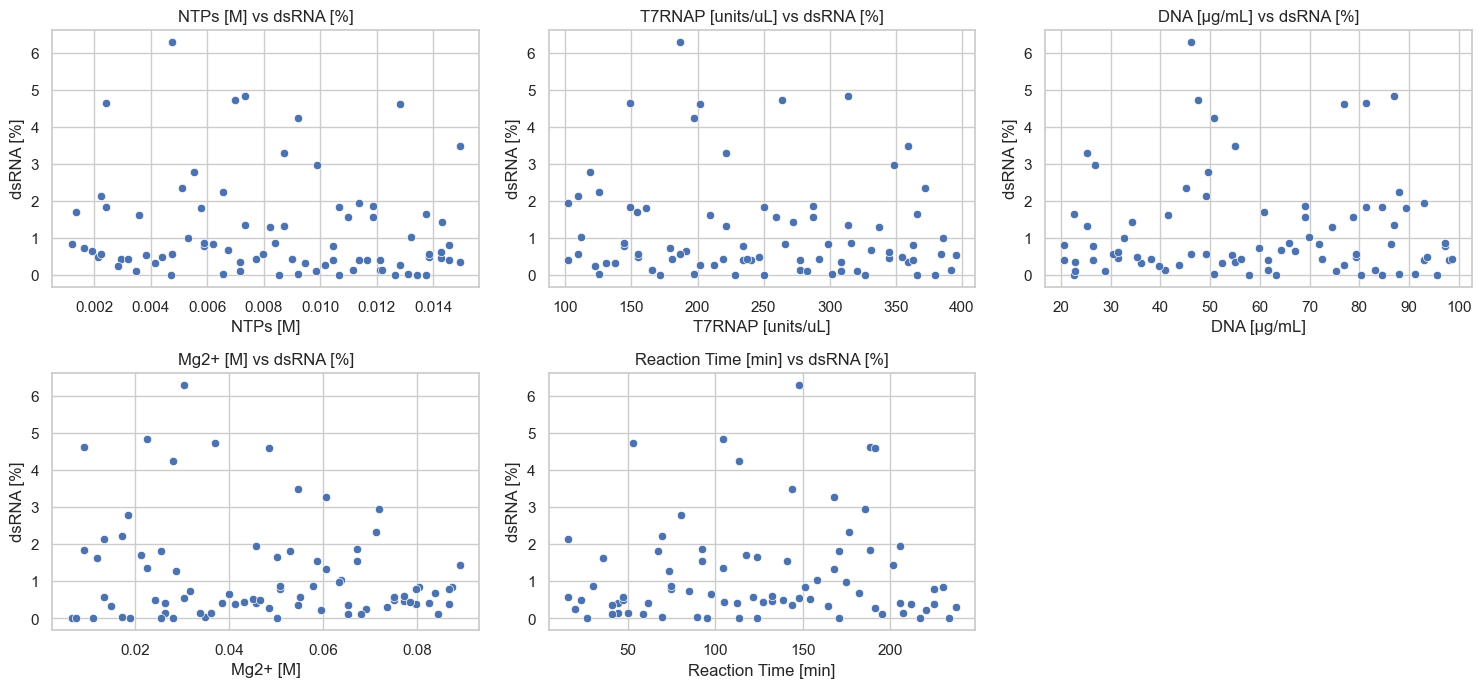

In [11]:
# plot the experimental conditions against the response in a grid
import matplotlib.pyplot as plt
import seaborn as sns

experimental_data = experimental_conditions.copy()
experimental_data[y_columns[0]] = responses
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
for i, col in enumerate(X_columns):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=experimental_data, x=col, y=y_columns[0])
    plt.title(f"{col} vs {y_columns[0]}")
    plt.xlabel(col)
    plt.ylabel(y_columns[0])
plt.tight_layout()

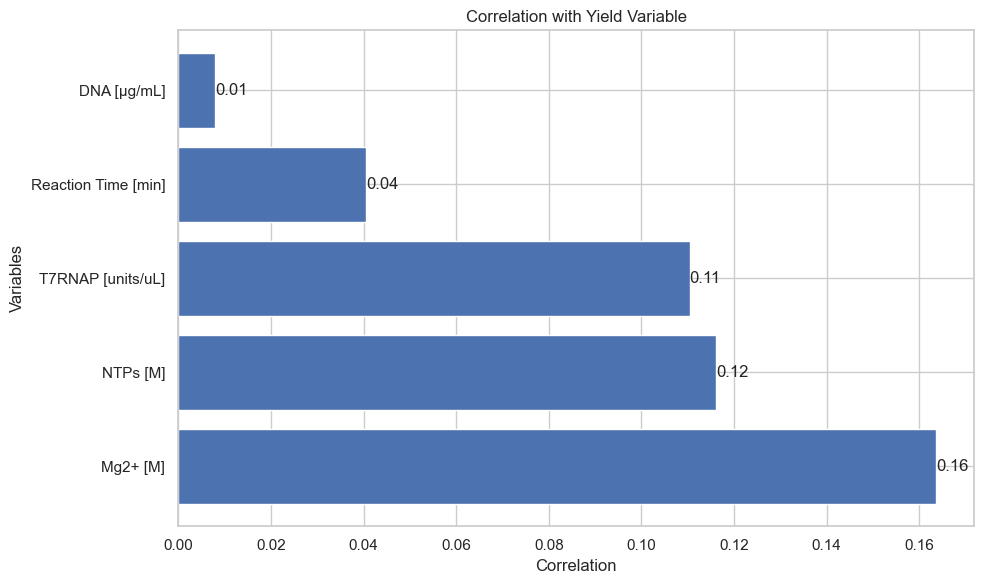

In [12]:
# Calculate the correlation coefficients with the yield variable
corr_matrix = experimental_data.corr()
correlations = corr_matrix[y_columns[0]].drop(y_columns[0])

# Sort the correlations in descending order
correlations = correlations.abs().sort_values(ascending=False)

# Create a horizontal bar chart of the correlations
plt.figure(figsize=(10, 6))
plt.barh(correlations.index, correlations.values)
plt.xlabel("Correlation")
plt.ylabel("Variables")
plt.title("Correlation with Yield Variable")
plt.tight_layout()
# add correlation values to the bars
for index, value in enumerate(correlations):
    plt.text(value, index, f"{value:.2f}", va="center")

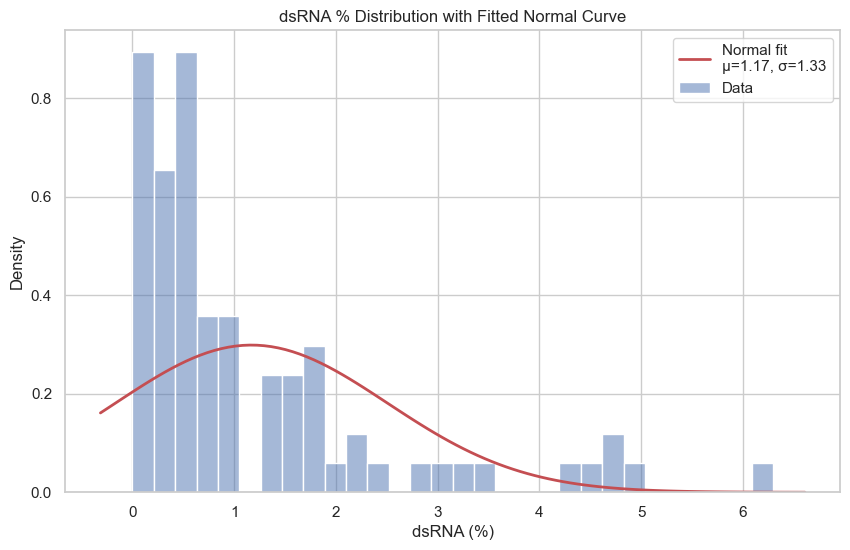

In [13]:
from scipy import stats
import numpy as np

# Fit a normal distribution
mu, std = stats.norm.fit(responses.values)

# Plot histogram and fitted PDF
plt.figure(figsize=(10, 6))
sns.histplot(
    responses.values, bins=30, kde=False, stat="density", color="skyblue", label="Data"
)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r", linewidth=2, label=f"Normal fit\nμ={mu:.2f}, σ={std:.2f}")
plt.title("dsRNA % Distribution with Fitted Normal Curve")
plt.xlabel("dsRNA (%)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Preliminary Model Fit


Root Mean squared error on training set: 1.3233723590128565
R-squared score on training: 0.017313048978928713


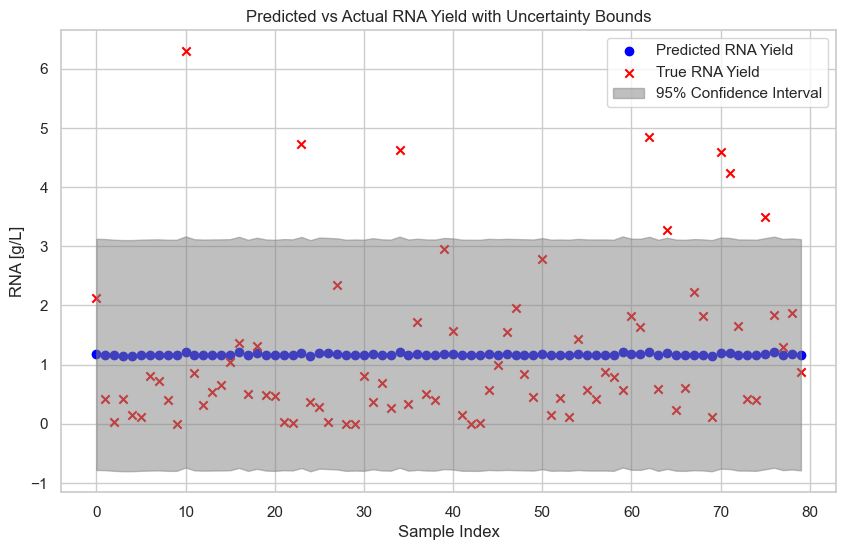

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

X_train, y_train = experimental_conditions[X_columns], responses[y_columns[0]]

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

df = pd.DataFrame(X_train_scaled, columns=X_columns)
df[y_columns[0]] = y_train_scaled

matern_gp_model = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2))
    * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5)
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=100,
    random_state=42,
)
matern_gp_model.fit(X_train_scaled, y_train_scaled)

# Training set predictions
pre_scaled_pred = matern_gp_model.predict(X_train_scaled)
predictions = scaler_y.inverse_transform(pre_scaled_pred.reshape(-1, 1)).flatten()
print(
    "Root Mean squared error on training set:",
    np.sqrt(mean_squared_error(y_train, predictions)),
)
print(
    "R-squared score on training:",
    matern_gp_model.score(X_train_scaled, y_train_scaled),
)

x_axis = np.arange(len(X_train))
plt.figure(figsize=(10, 6))
plt.scatter(
    x_axis,
    predictions,
    label="Predicted RNA Yield",
    color="blue",
    marker="o",
)
plt.scatter(x_axis, y_train, label="True RNA Yield", color="red", marker="x")
plt.fill_between(
    x_axis,
    predictions - 1.96 * np.sqrt(matern_gp_model.kernel_.k2.noise_level),
    predictions + 1.96 * np.sqrt(matern_gp_model.kernel_.k2.noise_level),
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Predicted vs Actual RNA Yield with Uncertainty Bounds")
plt.legend()

# Dimensionality Reduction

Using PCA and t-SNE to reduce the dimensionality of the dataset and visualize
patterns or clusters among samples.


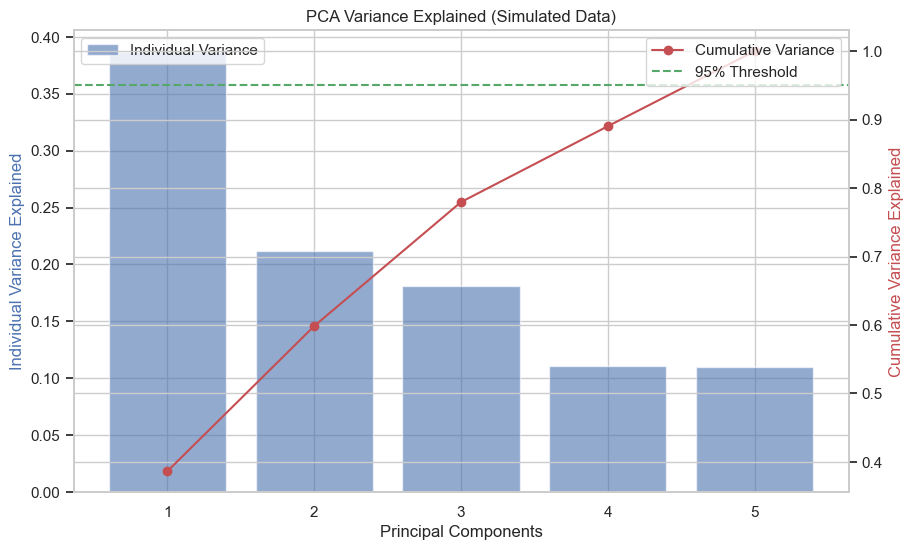

In [15]:
from sklearn.decomposition import PCA

# Apply PCA to the experimental_data (excluding the response column)
features = [col for col in experimental_data.columns if col != y_columns[0]]
pca = PCA(n_components=len(features))

# normalize the experimental data before PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(experimental_data[features])

pca.fit(X_scaled)

# Get loadings (components)
loadings = pca.components_.T

# Extract explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plotting
components = np.arange(1, len(explained_variance) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for individual variance
ax1.bar(
    components,
    explained_variance,
    alpha=0.6,
    label="Individual Variance",
    color="b",
)
# Line plot for cumulative variance
ax2 = ax1.twinx()
ax2.plot(
    components,
    cumulative_variance,
    marker="o",
    color="r",
    label="Cumulative Variance",
)
# Add 95% dotted line
ax2.axhline(y=0.95, color="g", linestyle="--", label="95% Threshold")

# Labels and title
ax1.set_xlabel("Principal Components")
ax1.set_ylabel("Individual Variance Explained", color="b")
ax2.set_ylabel("Cumulative Variance Explained", color="r")
ax1.set_title("PCA Variance Explained (Simulated Data)")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

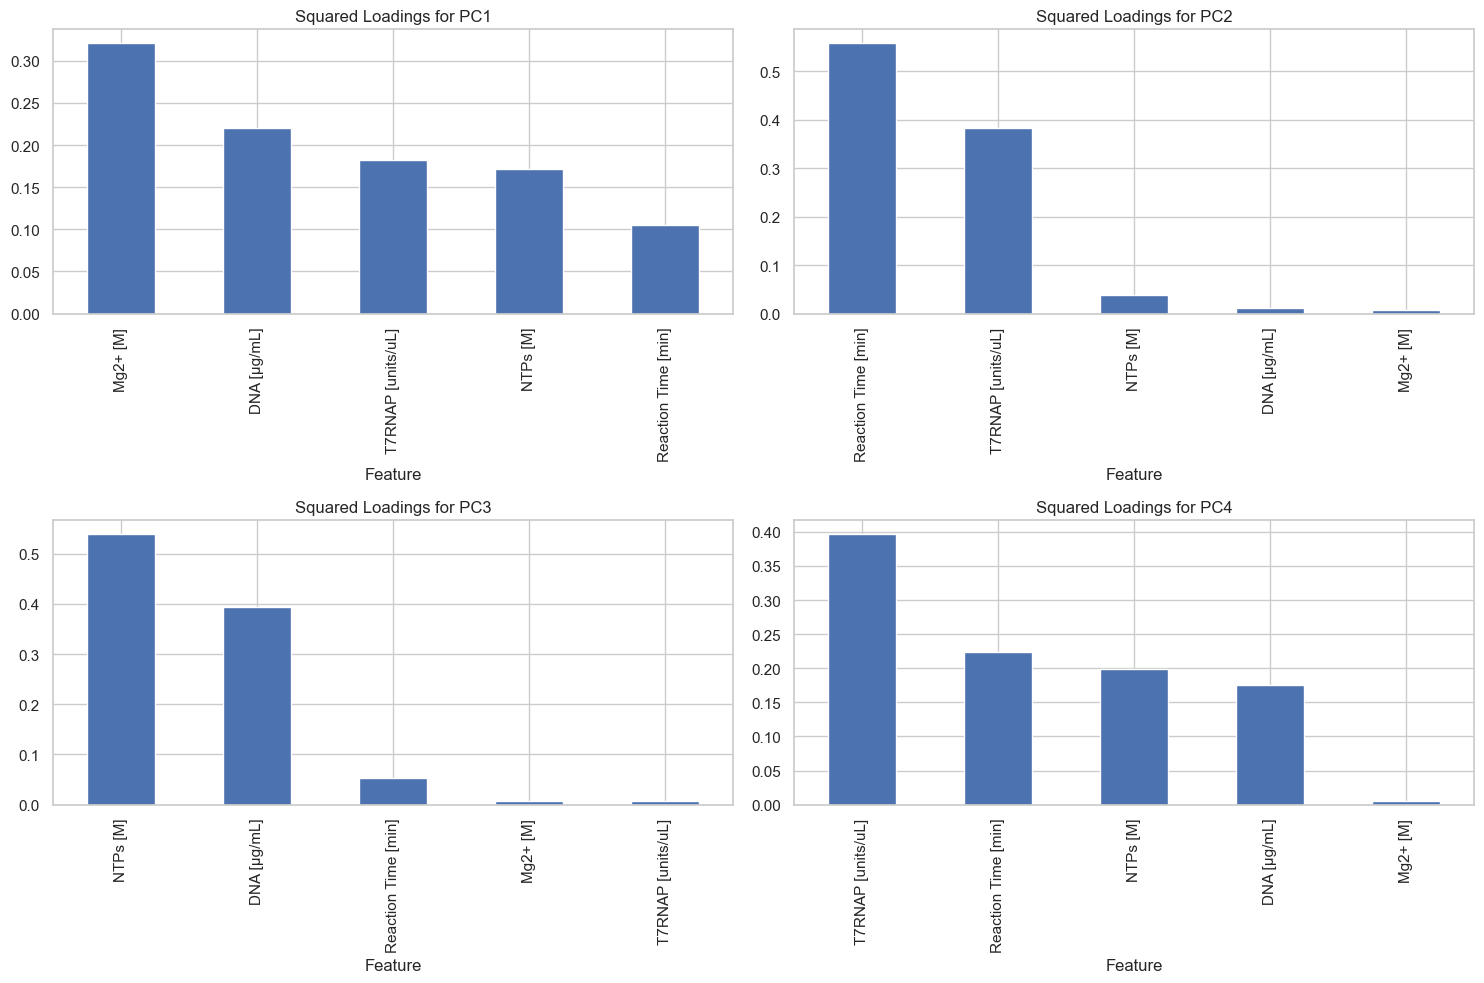

In [16]:
# Square the loadings for the first principal component
squared_loadings_pc1 = loadings[:, 0] ** 2
squared_loadings_pc2 = loadings[:, 1] ** 2
squared_loadings_pc3 = loadings[:, 2] ** 2
squared_loadings_pc4 = loadings[:, 3] ** 2

# show the pandas dataframe of the squared loadings with the feature names
squared_loadings_df = pd.DataFrame(
    {
        "Feature": features,
        "Squared Loading PC1": squared_loadings_pc1,
        "Squared Loading PC2": squared_loadings_pc2,
        "Squared Loading PC3": squared_loadings_pc3,
        "Squared Loading PC4": squared_loadings_pc4,
    }
)

# plot bar plots of the squared loadings for each principal component
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
squared_loadings_df.sort_values("Squared Loading PC1", ascending=False).plot.bar(
    x="Feature",
    y="Squared Loading PC1",
    ax=axes[0, 0],
    legend=False,
    title="Squared Loadings for PC1",
)
squared_loadings_df.sort_values("Squared Loading PC2", ascending=False).plot.bar(
    x="Feature",
    y="Squared Loading PC2",
    ax=axes[0, 1],
    legend=False,
    title="Squared Loadings for PC2",
)
squared_loadings_df.sort_values("Squared Loading PC3", ascending=False).plot.bar(
    x="Feature",
    y="Squared Loading PC3",
    ax=axes[1, 0],
    legend=False,
    title="Squared Loadings for PC3",
)
squared_loadings_df.sort_values("Squared Loading PC4", ascending=False).plot.bar(
    x="Feature",
    y="Squared Loading PC4",
    ax=axes[1, 1],
    legend=False,
    title="Squared Loadings for PC4",
)
plt.tight_layout()
plt.show()

Best number of components: 1
R-squared: 0.036518737705489746
Root Mean Squared Error: 1.3103765161255745


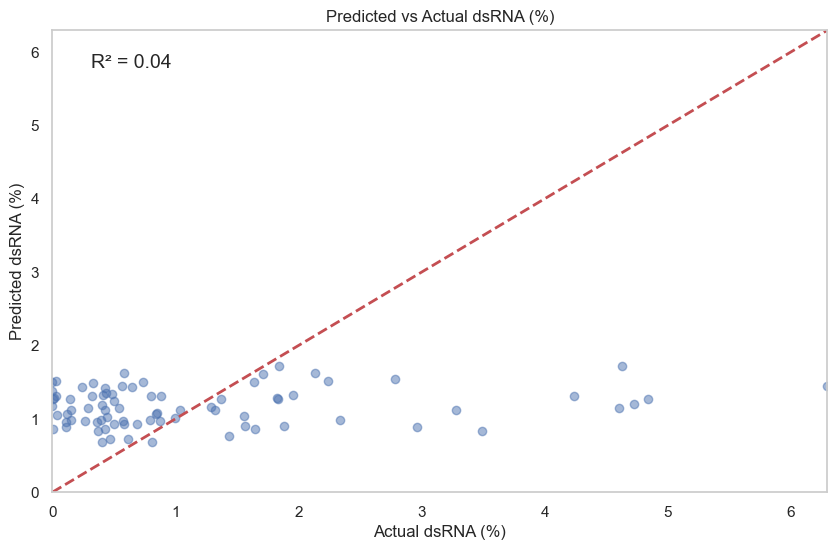

In [17]:
# normalize the experimental data before PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(experimental_data[features])
y_train_scaled = scaler.fit_transform(responses.values.reshape(-1, 1)).flatten()

# Create a PLS model
pls = PLSRegression()

# Use GridSearchCV to find the best number of components using KFold cross-validation
param_grid = {"n_components": list(range(1, 10))}
kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(pls, param_grid, cv=kf, scoring="neg_mean_squared_error")
grid_search.fit(X_train_scaled, y_train_scaled)

# Best number of components
best_n_components = grid_search.best_params_["n_components"]
print(f"Best number of components: {best_n_components}")

# Fit the PLS model with the best number of components
pls_best = PLSRegression(n_components=best_n_components)
pls_best.fit(X_train_scaled, y_train_scaled)

# Predict on the test set
Y_pred_scaled = pls_best.predict(X_train_scaled)

# Inverse transform the predicted values
predictions = scaler_y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()

# Calculate mean squared error and root mean squared error for the predictions
rmse = np.sqrt(mean_squared_error(y_train, predictions))
# Calculate R-squared for the predictions
r2 = r2_score(y_train, predictions)

# Print results
print(f"R-squared: {r2}")
print(f"Root Mean Squared Error: {rmse}")

# Plot the predicted vs actual RNA yield
plt.figure(figsize=(10, 6))
plt.scatter(y_train, predictions, alpha=0.5)
plt.text(
    0.05,
    0.95,
    f"R² = {r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=14,
    verticalalignment="top",
)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
plt.title("Predicted vs Actual dsRNA (%)")
plt.xlabel("Actual dsRNA (%)")
plt.ylabel("Predicted dsRNA (%)")
plt.xlim(y_train.min(), y_train.max())
plt.ylim(y_train.min(), y_train.max())
plt.grid()

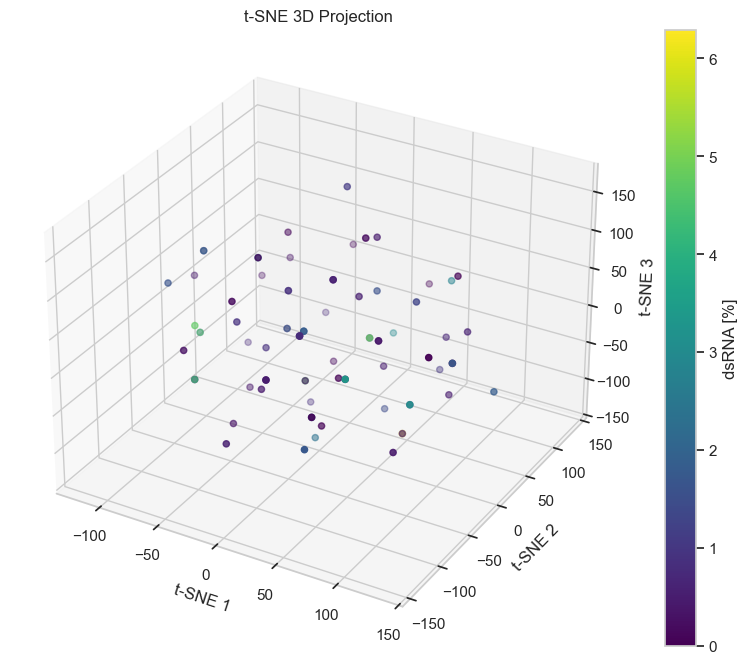

In [18]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE with 3 components
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    X_tsne_3d[:, 0],
    X_tsne_3d[:, 1],
    X_tsne_3d[:, 2],
    c=experimental_data[y_columns[0]],
    cmap="viridis",
)
ax.set_title("t-SNE 3D Projection")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
fig.colorbar(sc, label=y_columns[0])
plt.show()

# Clustering Analysis

Doing cluster analysis we could identify groups of samples with similar outcomes and
analyse their characteristics.


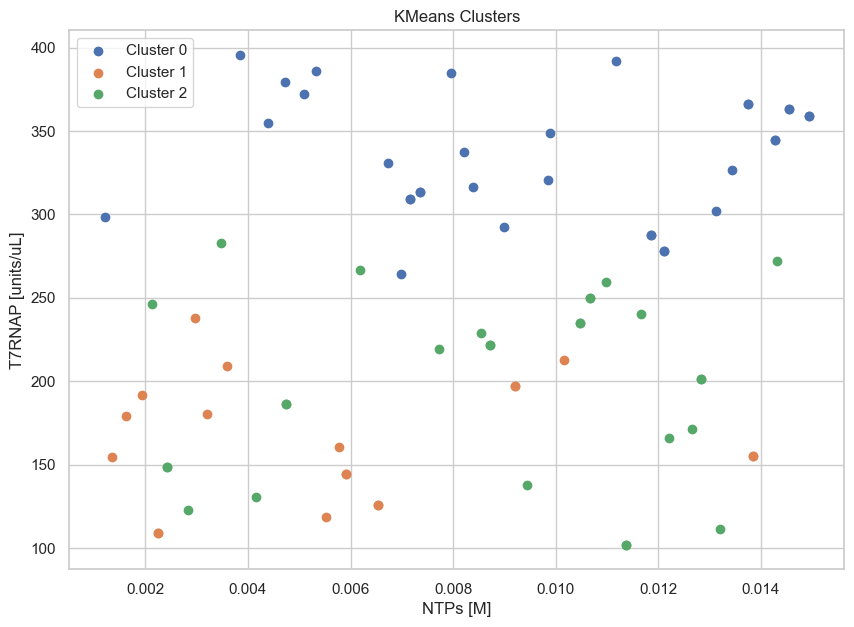

In [19]:
from sklearn.cluster import KMeans

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
experimental_data["Cluster"] = kmeans.fit_predict(experimental_data[features])

# Plot clusters in feature space (e.g., using first two features)
plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    subset = experimental_data[experimental_data["Cluster"] == cluster]
    plt.scatter(subset[features[0]], subset[features[1]], label=f"Cluster {cluster}")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title("KMeans Clusters")
plt.legend()
plt.show()

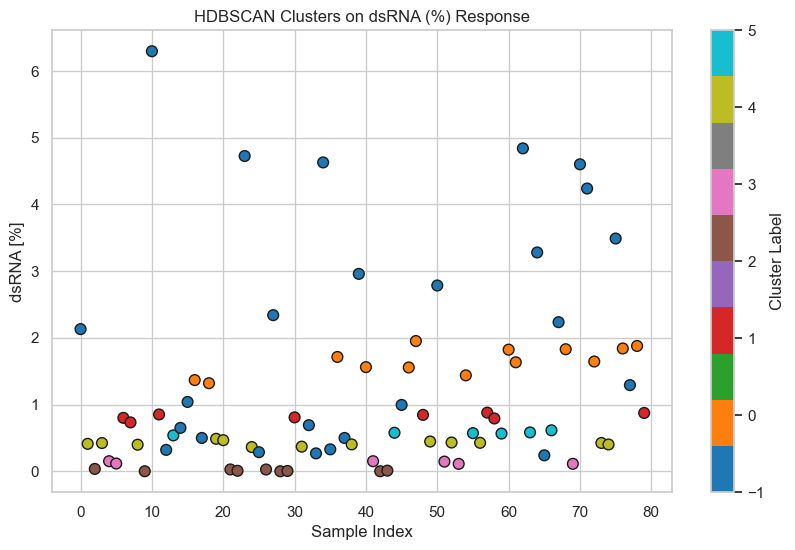

In [20]:
import hdbscan

# Fit HDBSCAN directly on the response values (reshaped to 2D)
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
hdbscan_labels_response = clusterer.fit_predict(y_train.values.reshape(-1, 1))

# Plot clusters in response space colored by cluster label
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    np.arange(len(y_train)),
    y_train,
    c=hdbscan_labels_response,
    cmap="tab10",
    s=60,
    edgecolor="k",
)
plt.xlabel("Sample Index")
plt.ylabel(y_columns[0])
plt.title("HDBSCAN Clusters on dsRNA (%) Response")
plt.colorbar(scatter, label="Cluster Label")
plt.show()

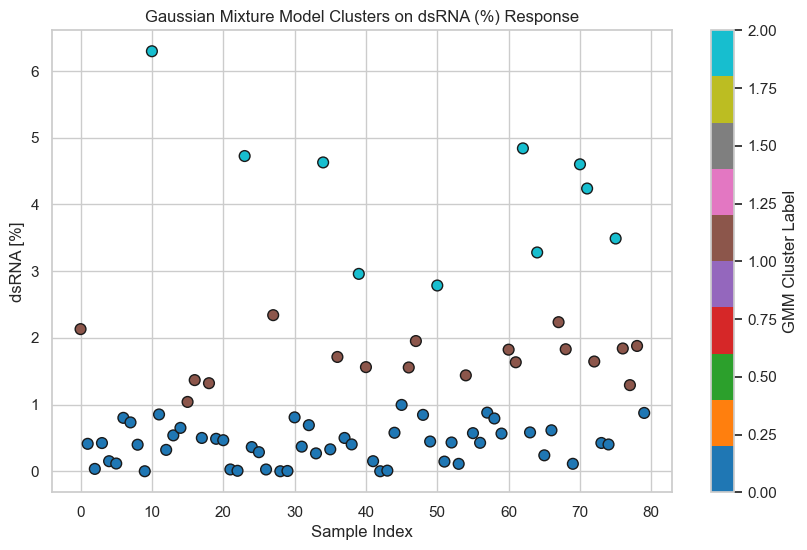

   Cluster_0_Prob  Cluster_1_Prob  Cluster_2_Prob
0    1.576129e-08        0.946134        0.053866
1    9.924146e-01        0.007488        0.000098
2    9.983383e-01        0.001599        0.000063
3    9.918883e-01        0.008010        0.000102
4    9.976851e-01        0.002255        0.000060


In [21]:
from sklearn.mixture import GaussianMixture

# Fit Gaussian Mixture Model on dsRNA percentage response
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(y_train.values.reshape(-1, 1))

# Plot clusters in response space colored by GMM cluster label
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    np.arange(len(y_train)),
    y_train,
    c=gmm_labels,
    cmap="tab10",
    s=60,
    edgecolor="k",
)
plt.xlabel("Sample Index")
plt.ylabel(y_columns[0])
plt.title("Gaussian Mixture Model Clusters on dsRNA (%) Response")
plt.colorbar(scatter, label="GMM Cluster Label")
plt.show()

# show the probability score of each sample belonging to each cluster
gmm_probs = gmm.predict_proba(y_train.values.reshape(-1, 1))
gmm_probs_df = pd.DataFrame(
    gmm_probs, columns=[f"Cluster_{i}_Prob" for i in range(gmm.n_components)]
)
print(gmm_probs_df.head())